In [39]:
import os
import qiime2 as q2
import pandas as pd
import numpy as np
from skbio import OrdinationResults, TreeNode
from scipy.stats import pearsonr, spearmanr, ttest_ind
from qiime2.plugins.emperor.actions import biplot
from qiime2.plugins.qurro.actions import differential_plot as qq2diffplot
from biom import Table
import glob
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.multitest import multipletests
from qiime2.plugins.phylogeny.methods import filter_table
#from qiime2.plugins.empress.actions import (community_plot, tree_plot)


import statsmodels.api as sm
import statsmodels.formula.api as smf

# plotting
import colorsys
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mc
from matplotlib.pyplot import cm
from matplotlib.colors import to_hex

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.style.use('ggplot')
%matplotlib inline


# set label font-sizes globally
paper_rc = {'lines.linewidth': 1, 
            'lines.markersize': 2}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12

def split_taxonomy(taxonomy):
    feat_map = dict(taxonomy.Taxon)
    taxonomy['Taxon'] = [feat_map[feat]
                         if feat in feat_map.keys()
                         else np.nan
                         for feat in taxonomy.index]
    # add taxonomic levels for grouping later (if available)

    def tax_split(tax_id, tax_level): return tax_id.split(
        tax_level)[1].split(';')[0]

    for level, lname in zip(['k__', 'p__', 'c__', 'o__',
                             'f__', 'g__', 's__'],
                            ['kingdom', 'phylum', 'class',
                             'order', 'family', 'genus',
                             'species']):
        if lname not in taxonomy.columns:
            taxonomy_tmp = []
            for tax in taxonomy.Taxon:
                if tax is not np.nan and\
                   level in tax and\
                   len(tax_split(tax, level)) > 0:
                    taxonomy_tmp.append(tax_split(tax,
                                                  level))
                else:
                    taxonomy_tmp.append(np.nan)
            taxonomy[lname] = taxonomy_tmp
    return taxonomy



def differential_plot(diff_df, level, color_by, x_axis, ax,
                      xtitle='log($\\frac{responder}{non-responder}$)',
                      cbartitle='Seeding-Effectiveness',
                      quartile_partition=True,
                      upper=.75, lower=.25, cmap_use='YlGnBu',
                      ntfilter=0, ensure_include = [],
                      n_top_bottom_filter=False,
                      n_top_bottom=50):

    # axis of std
    x_axis_std = x_axis.replace('_mean','_std')
    # make colormap
    # group level
    diff_df_grouped = diff_df.groupby(level).mean()
    # filter N-total
    keep_ = [k for k,v in dict(diff_df[level].value_counts()).items()
             if v > ntfilter]
    diff_df = diff_df[diff_df[level].isin(keep_)]
    # keep quartiles
    if quartile_partition:
        quant_ = diff_df_grouped[x_axis].quantile([lower, .5, upper]).values
        lower_ = list(diff_df_grouped[diff_df_grouped[x_axis] < quant_[0]].index)
        upper_ = list(diff_df_grouped[diff_df_grouped[x_axis] > quant_[-1]].index)
        diff_df = diff_df[diff_df[level].isin(lower_ + upper_ + ensure_include)]
    elif n_top_bottom_filter:  
        lower_ = list(diff_df_grouped[diff_df_grouped[x_axis] > 0].index[:n_top_bottom//2])
        upper_ = list(diff_df_grouped[diff_df_grouped[x_axis] <= 0].index[-n_top_bottom//2:])
        diff_df = diff_df[diff_df[level].isin(lower_ + upper_)]
    # remove some chars.
    diff_df[level] = [v_.replace('[','').replace(']','')
                      for v_ in diff_df[level]]
    # plot
    """sns.barplot(y=level,
                x=x_axis,
                palette=cmap_use,
                data=diff_df.sort_values('sort'),
                ax=ax,
                ci=68)"""
    # plot with std
    
    diff_df_grouped = diff_df.groupby(level).mean()
    diff_df_grouped[x_axis] -= diff_df_grouped[x_axis].mean()
    diff_df_grouped = diff_df_grouped.sort_values(x_axis)
    mean_values = diff_df_grouped[x_axis].values
    std_values = diff_df_grouped[x_axis_std].values
    y_labels = diff_df_grouped.index
    
    
    y_pos = np.arange(len(mean_values))
    color = cm.ocean_r(np.linspace(.2, 1, len(y_labels)))
    #color = cm.RdBu(np.linspace(0, 1, len(y_labels)))   
    
    pal_ = [c for i, c in zip(y_labels, color)]
    ax.barh(y_pos, mean_values, xerr=std_values, color=pal_,
            align='center', alpha=0.8, ecolor='black', capsize=5)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(y_labels)

    ax.set_ylabel('')
    ax.set_xlabel(xtitle,
                  color='black',
                  weight='bold',
                  fontsize=22)
    
    # fix backround
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')

    return ax, diff_df_grouped


In [37]:
# import tables
l5table = q2.Artifact.load('../data/metabolomics/matched-table-L5-metaG.qza')
bt_l5table = l5table.view(Table)
df_l5table = pd.DataFrame(bt_l5table.matrix_data.toarray(),
                          bt_l5table.ids('observation'), bt_l5table.ids())
metadata = q2.Metadata.load('../data/metaG/metaG-matched-metadata.qza').to_dataframe()

# differentials
diffs_l5 = pd.read_csv('../results/birdman-metab/L5_summarized_differentials.tsv', sep='\t', index_col=0)
diffs_l5 = diffs_l5.drop(['lizard','ant','beet','milk'])
for col_ in diffs_l5.columns:
    if '_mean' in col_:
        diffs_l5[col_] -= diffs_l5[col_].mean()
    else:
        diffs_l5[col_] = diffs_l5[col_] / np.sqrt(df_l5table.shape[1])
diffs_l5['food'] = diffs_l5.index


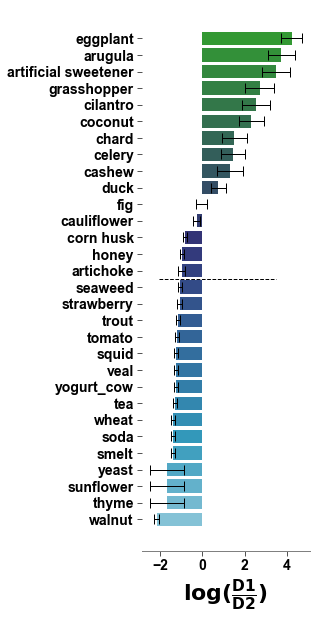

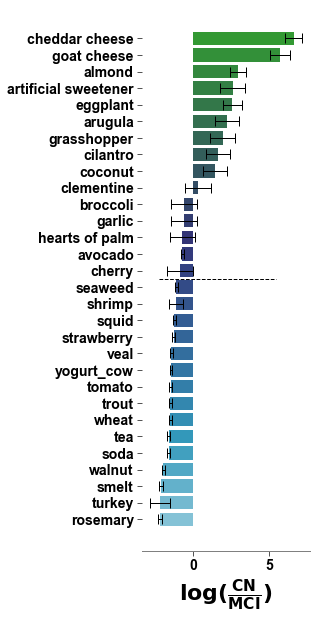

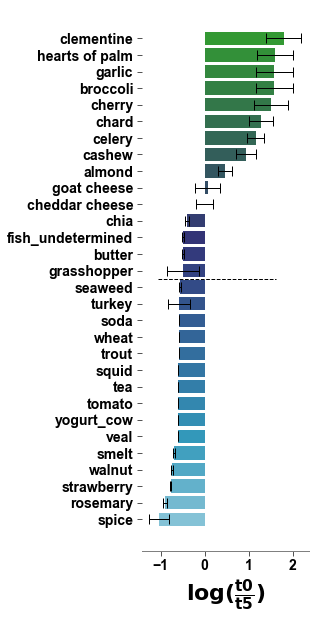

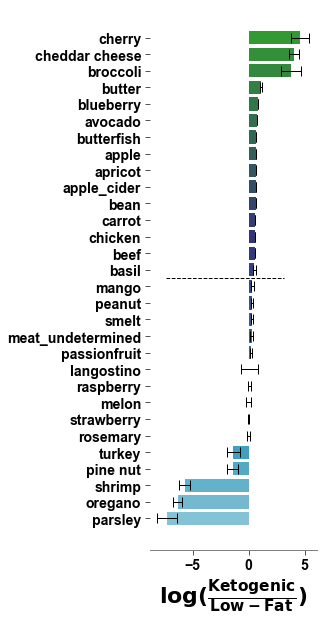

In [40]:
diff_plot = {"D1:D2":"first_diet_mean",
             "CN:MCI":"cog[T.NC]_mean",
             "t0:t5":"timepoint_encoded_mean",
             "Ketogenic:Low-Fat":"diet_nocross[T.Ketogenic Diet]_mean"}


metab_diff_df_plot = diffs_l5.copy()

level = 'food'

birdman_filttmp = {}

for label, diff_col in diff_plot.items():
    
    
    fig, ax = plt.subplots(1, 1, figsize=(3, 10))

    metab_comparedf = metab_diff_df_plot.copy()
    # remove features with "unreliable annotations"
    metab_comparedf = metab_comparedf.loc[metab_comparedf.index.difference(['worm', 'silversides'])]
    #metab_comparedf = metab_comparedf[metab_comparedf[diff_col].abs() > (metab_comparedf[diff_col.replace('_mean','_std')].abs() / 2)]

    title_ = 'log($\\frac{\\mathbf{%s}}{\\mathbf{%s}}$)' % (label.split(':')[0], label.split(':')[1])
    ax, df_tmp = differential_plot(metab_comparedf,
                                   level, diff_col, diff_col,
                                   ax,
                                   quartile_partition=False,
                                   ntfilter=0,
                                   n_top_bottom_filter=True,
                                   n_top_bottom=30,
                                   #upper=.99, lower=.01, 
                                   xtitle=title_)
    birdman_filttmp[label] = df_tmp

    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(14)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(14)
    #ax.set_xlim(-3, 3)
    #ax.spines['bottom'].set_bounds(-2, 2)
    ax.axhline((len(list(ax.get_yticklabels())) // 2) - .5,
               c='black', ls='--', lw=1,
               xmin=0.1, xmax=0.8)

    
    #plt.tight_layout()
    plt.savefig('../results/figures/ranking_%s.pdf' % (diff_col),dpi=1000, 
                bbox_inches='tight',
                facecolor=fig.get_facecolor(), 
                edgecolor='none')
    plt.savefig('../results/figures/low-res-ranking_%s.png' % (diff_col),dpi=250, 
                bbox_inches='tight',
                facecolor=fig.get_facecolor(), 
                edgecolor='none')
    plt.show()
    

In [19]:
num_ = birdman_filttmp['Ketogenic:Low-Fat'].index[-6:]
den_ = birdman_filttmp['Ketogenic:Low-Fat'].index[:6]
df_l5table_ps = df_l5table.copy() + 1
metadata_lr = metadata.copy().reindex(df_l5table_ps.columns)
metadata_lr['log_ratio'] = df_l5table_ps.loc[num_, :].sum(0) - df_l5table_ps.loc[den_, :].sum(0)
metadata_lr.head(5)


,age,anonymized_name,bmi_pbl,box_name,cog_visit_date,collection_timestamp,description,elevation,empo_1,empo_2,...,timepoint,title,tube_id,uom,visit_type,cog,diet,diet_nocross,timepoint_encoded,log_ratio
13662.5556815,60,1263024,21,31102 Stool Box 1,2/25/16,2016-02-23,fecal sample Post 1 3BCCR001024,300.0,Host-associated,Animal,...,Post 1,BEAM_U19,0005556815,mg,POSTA-COG,NC,Ketogenic Diet,Ketogenic Diet,2.0,406.0
13662.5556668,63,1263011,22.26,31102 Stool Box 1,6/11/15,2015-06-17,fecal sample Post 2 3BSLA000746,300.0,Host-associated,Animal,...,Post 2,BEAM_U19,0005556668,mg,POSTA-COG,NC,AHA Diet,AHA Diet,2.0,126.0
13662.5556717,66,1263017,27.8,31102 Stool Box 1,3/28/16,2016-03-28,fecal sample FU 1 / Pre 2 3TFBO000818,300.0,Host-associated,Animal,...,FU 1 / Pre 2,BEAM_U19,0005556717,mg,PREB-COG,NC,Keto-to-AHA Crossover,AHA Diet,3.0,0.0
13662.5556776,55,1263021,41.46,31102 Stool Box 1,11/30/15,2015-12-01,fecal sample Post 2 3CDMA000951,300.0,Host-associated,Animal,...,Post 2,BEAM_U19,0005556776,mg,POSTA-COG,NC,AHA Diet,AHA Diet,2.0,-50.0
13662.5556749,57,1263019,30.26,31102 Stool Box 1,1/12/16,2016-01-28,fecal sample FU 2 3LDMO000125,300.0,Host-associated,Animal,...,FU 2,BEAM_U19,0005556749,mg,POSTB-FU,MCI,AHA Diet,AHA Diet,5.0,92.0


In [20]:
def diet_plotting_col(x):
    if x['timepoint_encoded']==3: 
        if x['diet']=='AHA-to-Keto Crossover':
            return 'AHA Washout'
        elif x['diet']=='Keto-to-AHA Crossover':
            return 'Keto Washout'
    elif x['timepoint_encoded']==5:
        if x['diet']=='AHA Diet':
            return 'AHA Washout'
        elif x['diet']=='Ketogenic Diet':
            return 'Keto Washout'
    return x['diet'] 

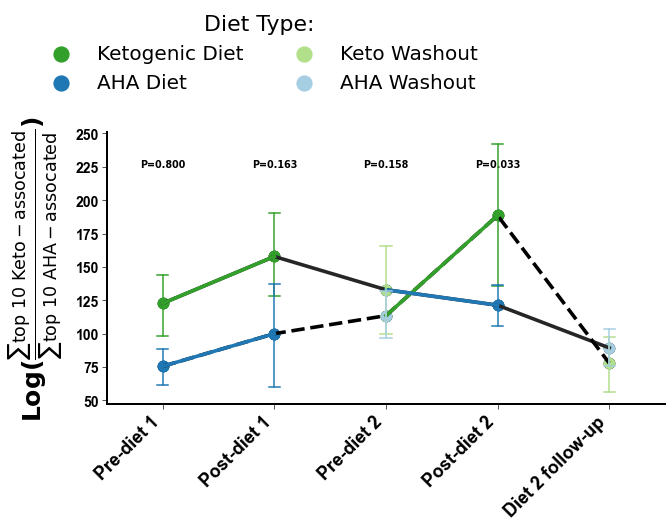

In [21]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 2}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 18 
plt.rcParams['ytick.labelsize'] = 8

cmap_man = {'AHA Diet':'#1f78b4',
            'AHA Washout':'#a6cee3',
            'Keto Washout':'#b2df8a',
            'Ketogenic Diet':'#33a02c'}

fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharex=True)



axn_i = 0

orddf = metadata_lr.copy()

"""denom_use_label = [x.replace('[', '').replace(']', '') for x in den_]
num_use_label = [x.replace('[', '').replace(']', '') for x in num_]

label_x = 'Log($\\frac{\mathrm{%s}}{\mathrm{%s}}$)' % (',\,\,'.join(num_use_label).replace(' ', '\,\,'),
                                                       ',\,\,'.join(denom_use_label).replace(' ', '\,\,'))
"""
label_x = 'Log($\\frac{\mathrm{\\sum{top\,\,10\,\,Keto-assocated}}}{\mathrm{\\sum{top\,\,10\,\,AHA-assocated}}}$)'

sns.pointplot(y='log_ratio', x='timepoint_encoded', hue='first_diet',
              data=orddf, color='black', ci=None, ax=ax,
              linestyles=['-','--'], errwidth=0)

# draw from point 1 to point 2 
# make nans at PC1 for everything except point1 and point2 
orddf_12 = orddf.copy()
orddf_12.loc[orddf_12['timepoint_encoded'] > 2, 'log_ratio'] = np.nan
sns.pointplot(y='log_ratio', x='timepoint_encoded', hue='diet_nocross',
             data=orddf_12, palette=cmap_man, ax=ax, ci=None)

# draw from point 3 to point 4 
# make nans at PC1 for everything except point3 and point4 
orddf_34 = orddf.copy()
orddf_34.loc[(orddf_34['timepoint_encoded'] < 3) | (orddf_34['timepoint_encoded'] == 5),'log_ratio'] = np.nan
sns.pointplot(y='log_ratio', x='timepoint_encoded', hue='diet_nocross',
             data=orddf_34, palette=cmap_man, ax=ax, ci=None)

orddf['diet_plotting'] = orddf.apply(diet_plotting_col, axis=1)
sns.pointplot(y='log_ratio', x='timepoint_encoded', hue='diet_plotting',
              data=orddf, ci=68, ax=ax, palette=cmap_man,
              errwidth=1.5, capsize=0.1, join=False)


relabel_ticks = {1:'Pre-diet 1', 2:'Post-diet 1', 
                 3:'Pre-diet 2', 4:'Post-diet 2', 
                 5:'Diet 2 follow-up'}
new_xtick = [relabel_ticks[float(x.get_text())] for x in ax.get_xticklabels()]
#ax.set_xticklabels(new_xtick)   
ax.set_xticklabels(new_xtick, rotation = 45, ha="right", fontsize=18, color='black', weight='bold')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(14)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(18)

ax.set_ylabel(label_x,
              color='black',
              weight='bold',
              labelpad=10,
              fontsize=25)


# fix backround
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    ax.spines[axis].set_color('black')
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')

"""ax.spines['bottom'].set_bounds(0, 4)
ax.spines['left'].set_bounds(0, 8)
ax.set_ylim(0, 8)"""

if axn_i == 0:

    ax.set_xlabel('',
              color='black',
              weight='bold',
              labelpad=20,
              fontsize=18)

    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles[6:], labels[6:],
                       loc=2, 
                             bbox_to_anchor=(-0.15, 1.5),
                             prop={'size':20},
                             title="Diet Type:",
                             fancybox=False, framealpha=.0,
                             ncol=2, markerscale=1.5)
    legend.get_title().set_fontsize('22')
    # increase the line width in the legend 
    for line in legend.get_lines()[:]:
        line.set_linewidth(2.0)
    for line in legend.get_lines()[:]:
        line.set_linewidth(2.0)
else:

    ax.set_xlabel('treatment period',
              color='black',
              weight='bold',
              labelpad=20,
              fontsize=18)

    ax.legend_.remove()

plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")


orddf['Period'] = [relabel_ticks[t_] for t_ in orddf.timepoint_encoded]
orddf['Sequence'] = orddf['first_diet']
orddf['Diet'] = orddf['diet_nocross']
md = smf.mixedlm("log_ratio ~ Sequence + Diet + Period + cog",
                 orddf,
                 groups=orddf["host_subject_id"])
mdf = md.fit()
mdf_table = mdf.summary().tables[1]

for x_i, ind in enumerate(['Period[T.Pre-diet 1]', 'Period[T.Post-diet 1]',
                           'Period[T.Pre-diet 2]', 'Period[T.Post-diet 2]']):

    p_str = "P=%s" % (mdf_table.loc[ind, 'P>|z|'])
    ax.text(x_i , 225,
            p_str,
            horizontalalignment='center',
            size='medium', color='black', weight='semibold')

    
plt.show()


In [22]:
mdf_table

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,94.461,41.546,2.274,0.023,13.031,175.890
Diet[T.Ketogenic Diet],33.638,17.284,1.946,0.052,-0.238,67.515
Period[T.Post-diet 1],38.058,27.294,1.394,0.163,-15.438,91.554
Period[T.Post-diet 2],57.172,26.867,2.128,0.033,4.515,109.830
Period[T.Pre-diet 1],6.900,27.294,0.253,0.800,-46.596,60.396
Period[T.Pre-diet 2],37.457,26.533,1.412,0.158,-14.547,89.461
cog[T.NC],38.812,25.176,1.542,0.123,-10.532,88.155
Sequence,-29.692,25.953,-1.144,0.253,-80.559,21.174
Group Var,1683.789,14.592,,,,


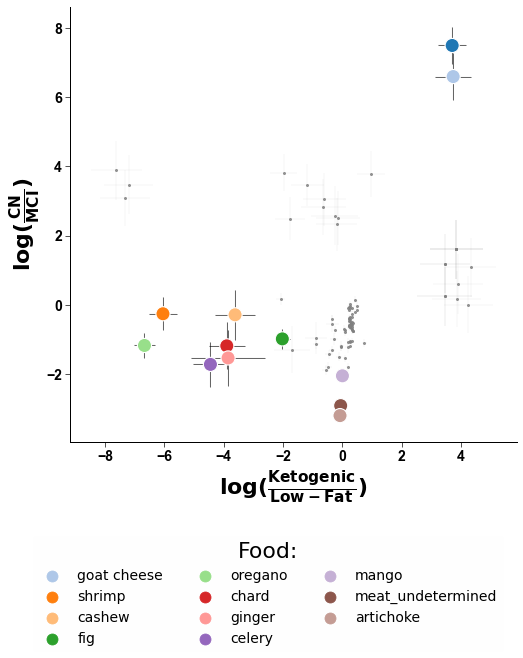

In [23]:
fig, ax = plt.subplots(1,1,figsize=(8,8))

label_x = "Ketogenic:Low-Fat"
title_x = 'log($\\frac{\\mathbf{%s}}{\\mathbf{%s}}$)' % (label_x.split(':')[0], label_x.split(':')[1])
label_y = "CN:MCI"
title_y = 'log($\\frac{\\mathbf{%s}}{\\mathbf{%s}}$)' % (label_y.split(':')[0], label_y.split(':')[1])

diff_col = 'diet_nocross[T.Ketogenic Diet]_mean'
#micro_comparedf = pd.concat([microbe_diff_df_plot, taxonomy], axis=1).dropna(subset=[level, diff_col])
#micro_comparedf = micro_comparedf[micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'] > -3]
micro_comparedf = diffs_l5.copy()
#micro_comparedf = micro_comparedf[micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'].abs() > micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'.replace('_mean','_std')].abs()]
rho_, p_ = spearmanr(micro_comparedf['cog[T.NC]_mean'].values,
                     micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'].values)
stats_txt = "$\\rho$=%.3f\nP=%.3f" % (rho_, p_)
props = dict(boxstyle='round', facecolor='gray', alpha=0.5)
#ax.text(0.1, 0.85, stats_txt, transform=ax.transAxes, bbox=props, ha='left', fontsize=14)

cut_off = 2
micro_comparedf_subset_color = micro_comparedf[((micro_comparedf['cog[T.NC]_mean'] < -2) ) \
                                               | ((micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'] < -1  *cut_off) \
                                                & (micro_comparedf['cog[T.NC]_mean'] < 0) ) \
                                               | (((micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'] > cut_off)\
                                                  & (micro_comparedf['cog[T.NC]_mean'] > cut_off)))]
micro_comparedf_subset_color = micro_comparedf_subset_color.sort_values('food')

sns.scatterplot(x='diet_nocross[T.Ketogenic Diet]_mean', y='cog[T.NC]_mean',
                hue='food', data=micro_comparedf_subset_color.sort_values('cog[T.NC]_mean', ascending=False),
                s=200, palette='tab20')

ax.errorbar(x=micro_comparedf_subset_color['diet_nocross[T.Ketogenic Diet]_mean'],
             y=micro_comparedf_subset_color['cog[T.NC]_mean'],
             xerr=micro_comparedf_subset_color['diet_nocross[T.Ketogenic Diet]_std'],
             yerr=micro_comparedf_subset_color['cog[T.NC]_std'],
             elinewidth = 0.6,
             color='black',
             fmt='o', zorder=-1)

ax.errorbar(x=micro_comparedf['diet_nocross[T.Ketogenic Diet]_mean'],
             y=micro_comparedf['cog[T.NC]_mean'],
             xerr=micro_comparedf['diet_nocross[T.Ketogenic Diet]_std'],
             yerr=micro_comparedf['cog[T.NC]_std'],
             elinewidth = 0.1,
             color='gray',
             alpha=.8,
             fmt='o', zorder=-1)

handles, labels_scatter = ax.get_legend_handles_labels()
legend = ax.legend(handles[1:], labels_scatter[1:],
                   loc=2, 
                         bbox_to_anchor=(-0.1, -0.2),
                         prop={'size':14},
                         title="Food:",
                         fancybox=True, framealpha=.01,
                         ncol=3, markerscale=5.5)


legend.get_title().set_fontsize('22')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)

ax.set_xlabel(title_x,
          color='black',
          weight='bold',
          fontsize=22)
ax.set_ylabel(title_y,
          color='black',
          weight='bold',
          fontsize=22)
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(14)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(14)
    
# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')

"""ax.spines['left'].set_bounds(-6, 4)
ax.spines['bottom'].set_bounds(-2, 4)"""
ax.grid(False)
        
plt.show()

In [24]:
labels_scatter[-6:]

['chard', 'ginger', 'celery', 'mango', 'meat_undetermined', 'artichoke']

In [25]:
num_ = labels_scatter[:2]
den_ = labels_scatter[2:]
df_l5table_ps = df_l5table.copy() + 1
metadata_lr = metadata.copy().reindex(df_l5table_ps.columns)
metadata_lr['log_ratio'] = df_l5table_ps.loc[num_, :].sum(0) - df_l5table_ps.loc[den_, :].sum(0)
metadata_lr.head(5)


,age,anonymized_name,bmi_pbl,box_name,cog_visit_date,collection_timestamp,description,elevation,empo_1,empo_2,...,timepoint,title,tube_id,uom,visit_type,cog,diet,diet_nocross,timepoint_encoded,log_ratio
13662.5556815,60,1263024,21,31102 Stool Box 1,2/25/16,2016-02-23,fecal sample Post 1 3BCCR001024,300.0,Host-associated,Animal,...,Post 1,BEAM_U19,0005556815,mg,POSTA-COG,NC,Ketogenic Diet,Ketogenic Diet,2.0,-8.0
13662.5556668,63,1263011,22.26,31102 Stool Box 1,6/11/15,2015-06-17,fecal sample Post 2 3BSLA000746,300.0,Host-associated,Animal,...,Post 2,BEAM_U19,0005556668,mg,POSTA-COG,NC,AHA Diet,AHA Diet,2.0,-8.0
13662.5556717,66,1263017,27.8,31102 Stool Box 1,3/28/16,2016-03-28,fecal sample FU 1 / Pre 2 3TFBO000818,300.0,Host-associated,Animal,...,FU 1 / Pre 2,BEAM_U19,0005556717,mg,PREB-COG,NC,Keto-to-AHA Crossover,AHA Diet,3.0,-8.0
13662.5556776,55,1263021,41.46,31102 Stool Box 1,11/30/15,2015-12-01,fecal sample Post 2 3CDMA000951,300.0,Host-associated,Animal,...,Post 2,BEAM_U19,0005556776,mg,POSTA-COG,NC,AHA Diet,AHA Diet,2.0,-332.0
13662.5556749,57,1263019,30.26,31102 Stool Box 1,1/12/16,2016-01-28,fecal sample FU 2 3LDMO000125,300.0,Host-associated,Animal,...,FU 2,BEAM_U19,0005556749,mg,POSTB-FU,MCI,AHA Diet,AHA Diet,5.0,-86.0


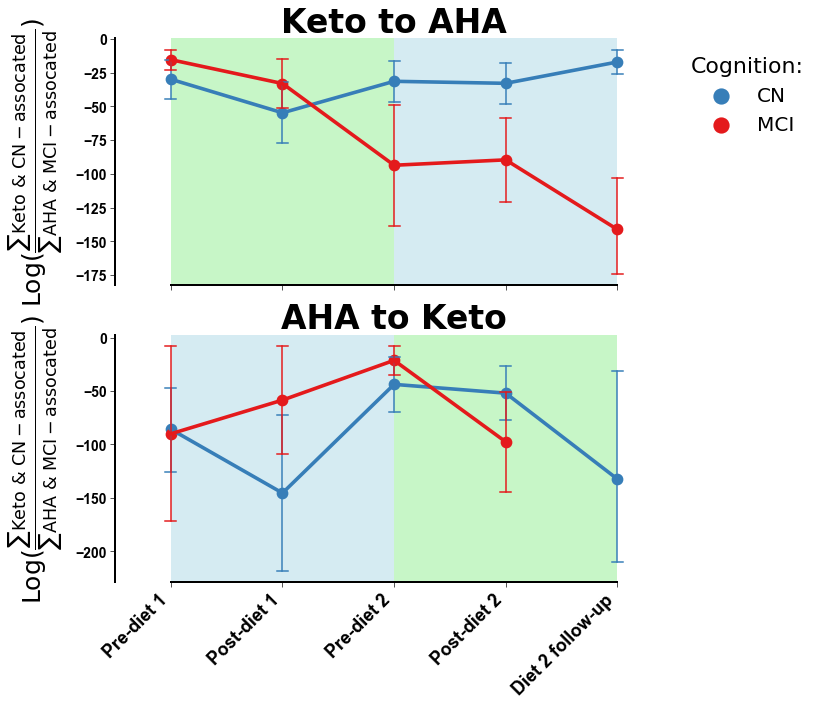

In [26]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 2}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 18 
plt.rcParams['ytick.labelsize'] = 8

cmap_man = {'NC':'#377eb8',
             'MCI':'#e41a1c'}


fig, axn = plt.subplots(2,1, figsize=(10,10), sharex=True)

subset_use = [1, 2]
subset_use_label = {1.0:'Keto to AHA', 2.0:'AHA to Keto'}

for (axn_i, ax), fsub in zip(enumerate(axn.flatten()), subset_use):

    orddf = metadata_lr.copy().dropna(subset=['first_diet'])
    orddf = orddf[orddf.first_diet == fsub]

    if fsub == 2:
        orddf = orddf[~((orddf.timepoint_encoded == 5.0) & (orddf.cog == 'MCI'))]
    
    ax.set_title(subset_use_label[fsub],
                  color='black',
                  weight='bold',
                  fontsize=33)
    
    if fsub == 1:
        # keto
        ax.axvspan(0, 2, facecolor='lightgreen', alpha=0.5)
        # low-fat
        ax.axvspan(2, 4, facecolor='lightblue', alpha=0.5)
    else:
        # low-fat
        ax.axvspan(0, 2, facecolor='lightblue', alpha=0.5)
        # keto
        ax.axvspan(2, 4, facecolor='lightgreen', alpha=0.5)

    denom_use_label = [x.replace('[', '').replace(']', '') for x in den_]
    #denom_use_label = [x.split(' ')[0][0] + '. ' + x.split(' ')[1] for x in denom_use_label]
    num_use_label = [x.replace('[', '').replace(']', '') for x in num_]
    #num_use_label = [x.split(' ')[0][0] + '. ' + x.split(' ')[1] for x in num_use_label]
    #label_x = 'Log($\\frac{\mathrm{%s}}{\mathrm{%s}}$)' % (',\,\,'.join(num_use_label).replace(' ', '\,\,'),
    #                                                       ',\,\,'.join(denom_use_label).replace(' ', '\,\,'))
    label_x = 'Log($\\frac{\mathrm{\sum{Keto\,\,&\,\,CN-assocated}}}{\mathrm{\sum{AHA\,\,&\,\,MCI-assocated}}}$)'

    #sns.pointplot(y='log_ratio', x='timepoint_encoded', hue='first_diet',
    #             data=orddf, color='black', ci=68, ax=ax,
    #              linestyles=['-','--'], errwidth=0)


    sns.pointplot(y='log_ratio', x='timepoint_encoded',
                  hue='cog',
                 data=orddf, palette=cmap_man,
                  ci=68, ax=ax,
                 errwidth=1.5,
                  capsize=0.1)


    relabel_ticks = {1:'Pre-diet 1', 2:'Post-diet 1', 3:'Pre-diet 2', 4:'Post-diet 2', 5:'Diet 2 follow-up'}
    new_xtick = [relabel_ticks[float(x.get_text())] for x in ax.get_xticklabels()]
    #ax.set_xticklabels(new_xtick)   
    ax.set_xticklabels(new_xtick, rotation = 45, ha="right", fontsize=18, color='black', weight='bold')

    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(14)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(18)

    ax.set_ylabel(label_x,
                  color='black',
                  weight='normal',
                  labelpad=10,
                  fontsize=25)


    # fix backround
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
        ax.spines[axis].set_color('black')
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')

    ax.spines['bottom'].set_bounds(0, 4)
    """ax.spines['left'].set_bounds(orddf['log_ratio'].min().round(1) + 1,
                                 orddf['log_ratio'].max().round(1) - 2)
    ax.set_ylim(orddf['log_ratio'].min().round(1) + 1,
                 orddf['log_ratio'].max().round(1) - 2)"""

    if axn_i < 2:
        
        ax.set_xlabel('',
                  color='black',
                  weight='bold',
                  labelpad=20,
                  fontsize=18)
        ax.legend_.remove()
        if axn_i== 0:

            handles, labels = ax.get_legend_handles_labels()
            legend = ax.legend(handles[:],
                               [l.replace('NC','CN') for l in labels[:]],
                               loc=2, 
                                     bbox_to_anchor=(1, 1.),
                                     prop={'size':20},
                                     title="Cognition:",
                                     fancybox=False, framealpha=.0,
                                     ncol=1, markerscale=1.5)
            legend.get_title().set_fontsize('22')
            # increase the line width in the legend 
            for line in legend.get_lines()[:]:
                line.set_linewidth(2.0)
            for line in legend.get_lines()[:]:
                line.set_linewidth(2.0)
    else:
        
        ax.set_xlabel('treatment period',
                  color='black',
                  weight='bold',
                  labelpad=20,
                  fontsize=18)
        
        ax.legend_.remove()
    
    plt.setp(ax.lines, zorder=100)
    plt.setp(ax.collections, zorder=100, label="")
    
    

plt.show()
